In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pickle

## Load and combine raw data from all three batches

In [3]:
batch1 = pickle.load(open(r'../Data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [4]:
numBat1 = len(batch1.keys())
numBat1

41

In [5]:
batch2 = pickle.load(open(r'../Data/batch2.pkl','rb'))

In [6]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [7]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [8]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [9]:
numBat2 = len(batch2.keys())
numBat2

43

In [10]:
batch3 = pickle.load(open(r'../Data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [11]:
numBat3 = len(batch3.keys())
numBat3

40

In [12]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [13]:
bat_dict = {**batch1, **batch2, **batch3}

## Calculate $\Delta Q_{100 - 10}$ features

In [14]:
def crop_data(id,cycle):
    # isolate discharging data
    cropped = np.array([[Q, V] for Q, V in zip(bat_dict[id]["cycles"][cycle]["Qd"], bat_dict[id]["cycles"][cycle]["V"]) if Q > 1e-5])
    for i, datapoint in enumerate(cropped):
        if datapoint[1] < cropped[i+1, 1]:
            if datapoint[1] < 2.2: # identify where discharging ends
                end = i+1
                break
            else: # this is an anomalous increase in voltage; remove so voltage is decreasing
                cropped[i+1, 1] = cropped[i, 1]
    cropped = cropped[:end]    
    x = np.flip(cropped[:, 1])
    y = np.flip(cropped[:, 0])
    return x,y

In [16]:
from scipy.stats import skew, kurtosis

xs = np.linspace(2,3.5,1000)

def interpolate_spline(id):
    x_100,y_100 = crop_data(id,"100")
    x_10,y_10 = crop_data(id,"10")

    cs_100 = UnivariateSpline(x_100,y_100,s=0.001)
    cs_10 = UnivariateSpline(x_10,y_10,s=0.001)
    return cs_10, cs_100

def get_var(id):
    cs_10, cs_100 = interpolate_spline(id)
    return np.log10(np.var(cs_100(xs) - cs_10(xs)))

def get_min(id):
    cs_10, cs_100 = interpolate_spline(id)
    return np.min(cs_100(xs) - cs_10(xs))

def get_skew(id):
    cs_10, cs_100 = interpolate_spline(id)
    return skew(cs_100(xs) - cs_10(xs))

def get_kurt(id):
    cs_10, cs_100 = interpolate_spline(id)
    return kurtosis(cs_100(xs) - cs_10(xs))

In [25]:
np.log10(bat_dict["b3c0"]["cycle_life"])[0][0]

3.0038911662369108

In [26]:
for id in bat_dict.keys():
    if id[1] in ["2", "3"]:
        bat_dict[id]["cycle_life"] = bat_dict[id]["cycle_life"][0][0]

In [27]:
var_list = []
min_list = []
skew_list = []
kurt_list = []
for id in bat_dict.keys():
    var_list.append([get_var(id),np.log10(bat_dict[id]["cycle_life"])])
    min_list.append([get_min(id),bat_dict[id]["cycle_life"]])
    skew_list.append([get_skew(id),bat_dict[id]["cycle_life"]])
    kurt_list.append([get_kurt(id),bat_dict[id]["cycle_life"]])
var_list = np.array(var_list)
min_list = np.array(min_list)
skew_list = np.array(skew_list)
kurt_list = np.array(kurt_list)

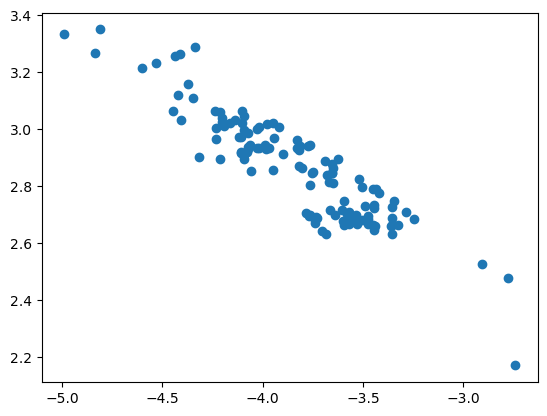

SignificanceResult(statistic=-0.8764323593903243, pvalue=1.5617035163309112e-40)


In [32]:
import scipy
plt.scatter(var_list[:,0],var_list[:,1])
plt.show()
#plt.xlim(left=-6,right=-2)
#plt.ylim(top=3.5,bottom=2)
print(scipy.stats.spearmanr(var_list[:,0],var_list[:,1]))

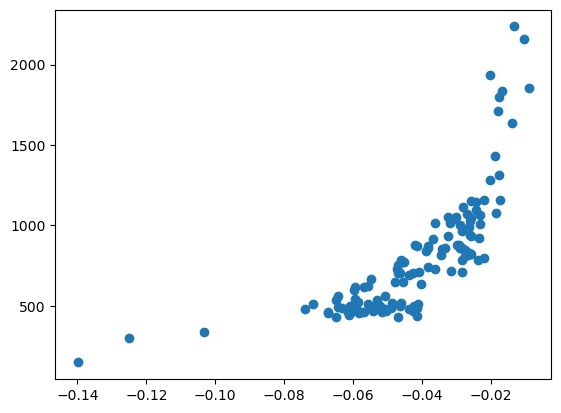

SignificanceResult(statistic=-0.8764323593903243, pvalue=1.5617035163309112e-40)


In [33]:
plt.scatter(min_list[:,0],min_list[:,1])
plt.show()
#plt.xlim(left=-6,right=-2)
#plt.ylim(top=3.5,bottom=2)
print(scipy.stats.spearmanr(var_list[:,0],var_list[:,1]))

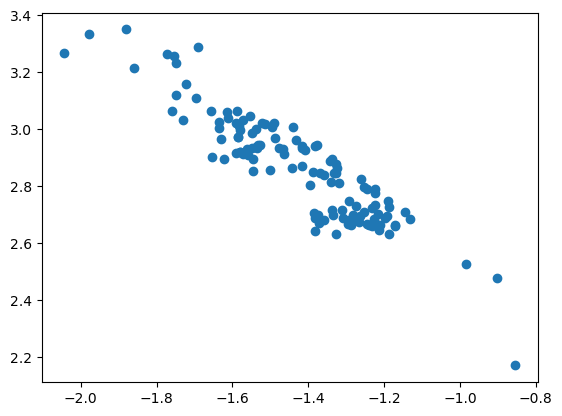

SignificanceResult(statistic=-0.8764323593903243, pvalue=1.5617035163309112e-40)


In [38]:
plt.scatter(np.log10(-min_list[:,0]),np.log10(min_list[:,1]))
plt.show()
#plt.xlim(left=-6,right=-2)
#plt.ylim(top=3.5,bottom=2)
print(scipy.stats.spearmanr(var_list[:,0],var_list[:,1]))

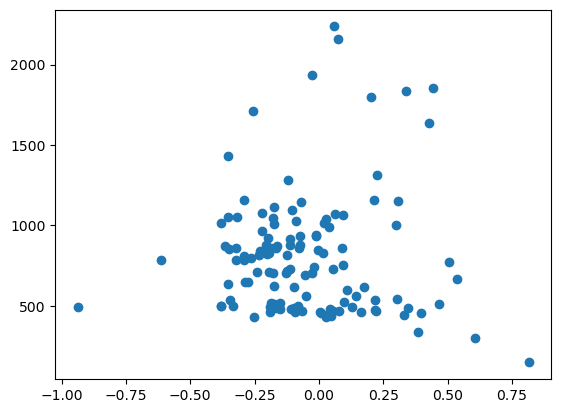

SignificanceResult(statistic=-0.8764323593903243, pvalue=1.5617035163309112e-40)


In [34]:
plt.scatter(skew_list[:,0],skew_list[:,1])
plt.show()
#plt.xlim(left=-6,right=-2)
#plt.ylim(top=3.5,bottom=2)
print(scipy.stats.spearmanr(var_list[:,0],var_list[:,1]))

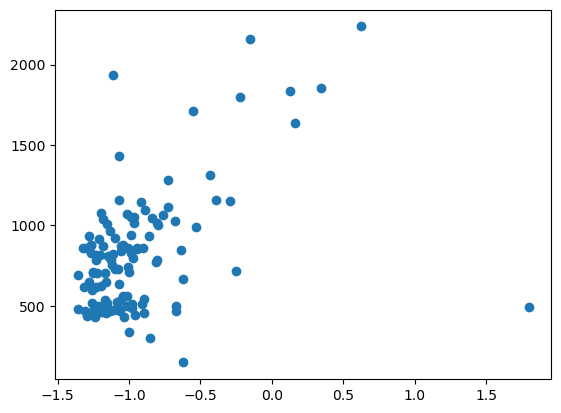

SignificanceResult(statistic=-0.8764323593903243, pvalue=1.5617035163309112e-40)


In [35]:
plt.scatter(kurt_list[:,0],kurt_list[:,1])
plt.show()
#plt.xlim(left=-6,right=-2)
#plt.ylim(top=3.5,bottom=2)
print(scipy.stats.spearmanr(var_list[:,0],var_list[:,1]))

In [33]:
np.savetxt('./Data/vardQ.csv',var_list,delimiter=',')

## Charge - Discharge pause extraction

In [50]:
bat_dict["b2c30"]["charge_policy"]

'5.2C(10%)-4.75C'

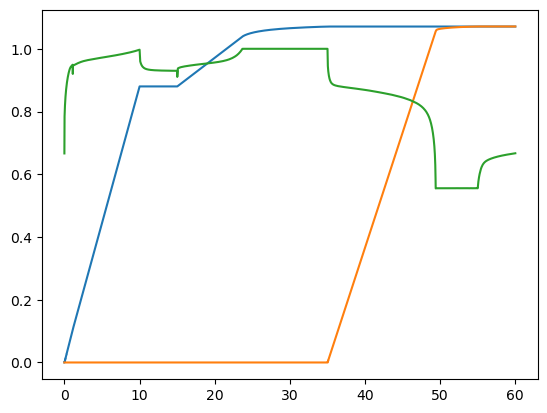

In [55]:
plt.plot(bat_dict["b2c30"]["cycles"]["10"]["t"], bat_dict["b2c30"]["cycles"]["10"]["Qc"])
plt.plot(bat_dict["b2c30"]["cycles"]["10"]["t"], bat_dict["b2c30"]["cycles"]["10"]["Qd"])
plt.plot(bat_dict["b2c30"]["cycles"]["10"]["t"], bat_dict["b2c30"]["cycles"]["10"]["V"]/np.max(bat_dict["b2c30"]["cycles"]["10"]["V"]))

## To load data from csv

Each row takes form [log10(variance), log10(cycle lifetime)]

In [35]:
var_data = np.loadtxt('./Data/vardQ.csv',delimiter=',',skiprows=1) # skip row for column names

array([[-4.84,  3.27],
       [-4.99,  3.33],
       [-4.81,  3.35],
       [-4.37,  3.16],
       [-4.53,  3.23],
       [-4.14,  3.03],
       [-3.76,  2.8 ],
       [-3.81,  2.94],
       [-3.95,  3.02],
       [-4.09,  2.9 ],
       [-4.06,  2.94],
       [-3.95,  2.86],
       [-4.07,  2.94],
       [-3.97,  2.93],
       [-3.68,  2.84],
       [-3.62,  2.9 ],
       [-3.36,  2.73],
       [-3.34,  2.75],
       [-4.02,  3.01],
       [-3.92,  3.01],
       [-3.99,  2.93],
       [-3.78,  2.94],
       [-3.82,  2.93],
       [-3.83,  2.93],
       [-3.83,  2.96],
       [-3.75,  2.85],
       [-3.77,  2.94],
       [-3.65,  2.86],
       [-3.65,  2.88],
       [-3.82,  2.87],
       [-3.75,  2.85],
       [-3.65,  2.85],
       [-3.65,  2.81],
       [-3.45,  2.79],
       [-3.5 ,  2.8 ],
       [-4.07,  2.98],
       [-4.1 ,  3.02],
       [-3.65,  2.85],
       [-3.67,  2.81],
       [-3.43,  2.79],
       [-3.42,  2.78],
       [-2.78,  2.48],
       [-2.74,  2.17],
       [-3.

## Train and Test Split
If you are interested in using the same train/test split as the paper, use the indices specified below

In [ ]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);